In [2]:
import os
import numpy as np
import pandas as pd

In [3]:
seed: int = 42

In [4]:
def read_csv(file: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(os.getcwd(), f"dataset/{file}"))
    return df

In [5]:
titanic = read_csv("train_engineered.csv")
titanic_copy = titanic.copy()

In [6]:
titanic_copy.columns.values

array(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'Age_present', 'Embarked_present'],
      dtype=object)

In [7]:
titanic_copy["Embarked"] = titanic_copy['Embarked'].replace(np.nan, "S")

In [8]:
titanic_copy['Is_child'] = np.select([titanic_copy['title'].str.lower() == 'master'], ['Y'], 'N')
titanic_copy['Nb_Fmly_Mem'] = titanic_copy['SibSp'].fillna(0) + titanic_copy['Parch'].fillna(0)

In [9]:
young_men = titanic_copy.loc[titanic_copy['title'] == "Master"]
adult_men = titanic_copy.loc[(titanic_copy['title'] != "Master") & (titanic_copy['Sex'] == "male")]


print(f"Median Boy Age -> {young_men['Age'].median()}. Median Men Age -> {adult_men['Age'].median()}")


Median Boy Age -> 3.5. Median Men Age -> 30.0


In [11]:
first_class = titanic_copy.loc[titanic_copy['Pclass'] == 1]
second_class = titanic_copy.loc[titanic_copy['Pclass'] == 2]
third_class = titanic_copy.loc[titanic_copy['Pclass'] == 3]

print(f"Median fare paid per class. 1st class -> {first_class['Fare'].median()}, 2nd class -> {second_class['Fare'].median()}, 3rd class -> {third_class['Fare'].median()}")

Median fare paid per class. 1st class -> 60.287499999999994, 2nd class -> 14.25, 3rd class -> 8.05


In [218]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(titanic_copy, test_size=0.2, random_state=seed, stratify=titanic_copy["Survived"])

In [162]:
y_train = train["Survived"]
del train["Survived"]

y_test = test["Survived"]
del test["Survived"]
    

In [233]:
titanic_copy.isna().any()

Survived            False
Pclass              False
Sex                 False
Age                  True
SibSp               False
Parch               False
Fare                False
Embarked            False
title               False
Age_present         False
Embarked_present    False
Is_child            False
Nb_Fmly_Mem         False
dtype: bool

In [219]:
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, FunctionTransformer


numeric_features = ["Age"]
ordinal_features = ["Pclass"]
categorical_features = ["Sex", "SibSp", "Parch", "Embarked", "title", "Embarked_present", "Is_child", "Age_present"]

numeric_transformer = Pipeline([("scaler", RobustScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="error")
ordinal_transformer = OrdinalEncoder(handle_unknown="error")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("ord", ordinal_transformer, ordinal_features),
    ]
)

In [83]:
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from lightgbm import LGBMClassifier

classifiers = {
    "logit": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LogisticRegression(random_state=seed))]),
    "rf": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", RandomForestClassifier(random_state=seed))]),
    "lbgm": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", LGBMClassifier(random_state=seed))]),
    "neural": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", MLPClassifier(random_state=seed))]),
    # "nb": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", GaussianNB())]),
    "ada": Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", AdaBoostClassifier(random_state=seed))]),
}

In [85]:
import seaborn as sns    
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

reports = []
kfold_results = []
names = []

for name, classifier in classifiers.items():
    names.append(name)
    
    # kfold
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    kfold_result = cross_val_score(classifier, train, y_train, cv=kfold, scoring='accuracy')
    kfold_results.append(kfold_result)
    
    # train test split
    classifier.fit(train, y_train)
    predictions = classifier.predict(test)
    reports.append({
        'name': name,
        'confusion': confusion_matrix(y_test, predictions),
        'accuracy': accuracy_score(y_test, predictions),
        'f1': f1_score(y_test, predictions)
    })

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\AppDa

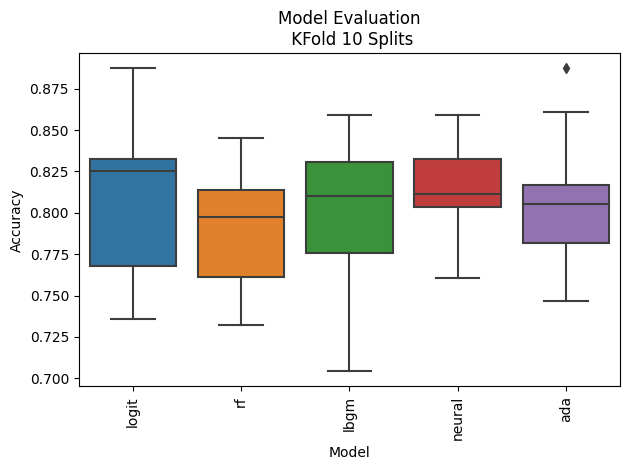

In [86]:

import seaborn as sns

g = sns.boxplot(data=kfold_results)
g.set_title('Model Evaluation\n KFold 10 Splits')
g.set_xlabel('Model')
g.set_ylabel('Accuracy')
g.set_xticklabels(names, rotation=90)
g.get_figure().tight_layout()

In [87]:
def print_model_stats(kfold_result, report):
    tn = report['confusion'][0][0] # True negative
    fp = report['confusion'][0][1] # False positive
    fn = report['confusion'][1][0] # False negative
    tp = report['confusion'][1][1] # True positive
    
    mr = 1 - report['accuracy'] # Misclassification rate
    tpr = tp / (fn + tp) # True positive rate
    fpr = fp / (tn + fp) # False positive rate
    spec = 1 - fpr # Specificity
    prec = tp / (fp + tp) # Precision    
    
    print('--------------------')
    print(report['name'])
    print('--------------------')
    print('F1 Score:        ', report['f1'])
    print('Accuracy:        ', report['accuracy'])
    print('Mean KFold (10): ', kfold_result.mean())
    print('Std. KFold (10): ', kfold_result.std())
    print('TPR:             ', tpr)
    print('FPR:             ', fpr)
    print('Specificity:     ', spec)
    print('Precision:       ', prec)
    print()
    
for kfold, report in zip(kfold_results, reports):
    print_model_stats(kfold_result, report)

--------------------
logit
--------------------
F1 Score:         0.782608695652174
Accuracy:         0.8324022346368715
Mean KFold (10):  0.8077856025039123
Std. KFold (10):  0.04056765844848901
TPR:              0.782608695652174
FPR:              0.13636363636363635
Specificity:      0.8636363636363636
Precision:        0.782608695652174

--------------------
rf
--------------------
F1 Score:         0.7338129496402879
Accuracy:         0.7932960893854749
Mean KFold (10):  0.8077856025039123
Std. KFold (10):  0.04056765844848901
TPR:              0.7391304347826086
FPR:              0.17272727272727273
Specificity:      0.8272727272727273
Precision:        0.7285714285714285

--------------------
lbgm
--------------------
F1 Score:         0.759124087591241
Accuracy:         0.8156424581005587
Mean KFold (10):  0.8077856025039123
Std. KFold (10):  0.04056765844848901
TPR:              0.7536231884057971
FPR:              0.14545454545454545
Specificity:      0.8545454545454545
Preci

In [88]:
! pip install scikit-learn-intelex

In [104]:

import warnings
warnings.filterwarnings("ignore", message="Numerical issues were encountered ")

from sklearn.model_selection import GridSearchCV

hyperparameters = {
    "logit": {"param_grid": 
        {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
         'classifier__penalty': ["none", "l2", "l1"], 
         'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        }},
    "rf": {"param_grid": {
        'classifier__max_features' : ["auto", "sqrt", "log2"],
        'classifier__min_samples_split' : np.linspace(0.1, 1.0, 10),
        'classifier__max_depth' : [x for x in range(1,20)]
    }},
    "ada": {"param_grid": {
        'classifier__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0],
        'classifier__n_estimators' : [10, 50, 100, 500]
    }},
    "lbgm": {"param_grid": {
        'classifier__bagging_fraction': (0.5, 0.8),
        'classifier__bagging_frequency': (5, 8),
        'classifier__feature_fraction': (0.5, 0.8),
        'classifier__max_depth': (10, 13),
        'classifier__min_data_in_leaf': (90, 120),
        'classifier__num_leaves': (1200, 1550)
    }},
    "neural": {"param_grid": {
        'classifier__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__alpha': [0.0001, 0.05],
        'classifier__max_iter': [200, 300, 400, 500],
        'classifier__learning_rate': ['constant','adaptive']
    }}
}

best_params = {}

for key, params in hyperparameters.items():
    param_grid = params["param_grid"]
    model = classifiers[key]
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= 10, n_jobs = -1, error_score=0.0)
    grid_search.fit(train, y_train)
    
    best_params[key] = grid_search.best_params_
    
    print(key, grid_search.best_params_, grid_search.best_score_)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
280 fits failed out of a total of 1050.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-pack

logit {'classifier__C': 0.001, 'classifier__penalty': 'none', 'classifier__solver': 'newton-cg'} 0.8162949921752739
rf {'classifier__max_depth': 12, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 0.1} 0.8092723004694836
ada {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 500} 0.8135367762128325
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
lbgm {'classifier__bagging_fraction': 0.8, 'classifier__bagging_frequency': 5, 'classifier__feature_fraction': 0.5, 'classifier__max_depth': 10, 'classifier__min_data_in_leaf': 90, 'classifier__num_leaves': 1550} 0.8289514866979655
neural {'class

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [92]:

for name, classifier in classifiers.items():
    y_pred = classifier.predict(test)
        # 'confusion': confusion_matrix(y_test, predictions),
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{name}. Accuracy -> {accuracy: .3f} F1 -> {f1: .3f}")

logit. Accuracy ->  0.832 F1 ->  0.783
rf. Accuracy ->  0.793 F1 ->  0.734
lbgm. Accuracy ->  0.816 F1 ->  0.759
neural. Accuracy ->  0.788 F1 ->  0.716
ada. Accuracy ->  0.777 F1 ->  0.714


In [119]:


for key1, value1 in best_params.items():
    tmp_dict = dict()
    for key2, value2 in value1.items():
        key = key2.replace("classifier__", "")
        tmp_dict[key] = value2
    best_params[key1] = tmp_dict
    
print(best_params)

{'logit': {'penalty': 'none', 'solver': 'newton-cg'}, 'rf': {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_split': 0.1}, 'ada': {'learning_rate': 0.1, 'n_estimators': 500}, 'lbgm': {'bagging_fraction': 0.8, 'bagging_frequency': 5, 'feature_fraction': 0.5, 'max_depth': 10, 'min_data_in_leaf': 90, 'num_leaves': 1550}, 'neural': {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}}


In [125]:
from sklearn.ensemble import VotingClassifier

models = {"logit": LogisticRegression(**best_params["logit"]), "rf": RandomForestClassifier(**best_params["rf"]), \
    "ada": AdaBoostClassifier(**best_params["ada"]), "neural": MLPClassifier(**best_params["neural"]), "lbgm": LGBMClassifier(**best_params["lbgm"])}

voting_classifier = VotingClassifier(n_jobs=-1, estimators=[(x, y) for x, y in models.items()], voting="soft")

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("sampling", SMOTE()), ("classifier", voting_classifier)])
pipe.fit(train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'SibSp', 'Parch',
                                                   'Embarked', 'title',
                                                   'Embarked_present',
                                                   'Age_present']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['Pclass'])])),
                ('sampling', SMOTE()),
                ('classifier...
                                               RandomForestClassifier(max_depth=12,
                                                                      min_samples_split=0.1)),
                                              ('ada',
                                               AdaBoostClassifier(learning_rate=0.1,
                                                                  n_estimators=500)),
                                              ('neural',
                                               MLPClassifier(activation='tanh',
                                                             alpha=0.05,
                                                             hidden_layer_sizes=(50,
                                                                                 100,
                                                                                 50))),
                                              ('lbgm',
                                               LGBMClassifier(bagging_fraction=0.8,
                                                              bagging_frequency=5,
                                                              feature_fraction=0.5,
                                                              max_depth=10,
                                                              min_data_in_leaf=90,
                                                              num_leaves=1550))],
                                  n_jobs=-1, voting='soft'))])

In [126]:
pipe.score(test, y_test)

0.8379888268156425

In [130]:
test_copy = read_csv("test.csv")

def courtesy_title(name):
    return name.split(',')[-1].split('.')[0].strip()

def add_column_present(df, colname):
    df[f"{colname}_present"] =  np.where(df[colname] != 'NaN', 1, 0)
    
def group_courtesy_title(title):
    keep_titles = ('Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev')
    if title not in keep_titles:
        title = 'Other'
        
    return title

test_copy["title"] = test_copy['Name'].apply(courtesy_title)
passenger_ids = test_copy['PassengerId']
test_copy = test_copy.drop(["Name", "Cabin", "PassengerId"], axis=1)
test_copy['title'] = test_copy['title'].apply(group_courtesy_title)
colnames = ["Age", "Embarked"]
for colname in colnames:
    add_column_present(test_copy, colname)
    

test_copy.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,title,Age_present,Embarked_present
0,3,male,34.5,0,0,330911,7.8292,Q,Mr,1,1
1,3,female,47.0,1,0,363272,7.0000,S,Mrs,1,1
2,2,male,62.0,0,0,240276,9.6875,Q,Mr,1,1
3,3,male,27.0,0,0,315154,8.6625,S,Mr,1,1
4,3,female,22.0,1,1,3101298,12.2875,S,Mrs,1,1


In [132]:
test_copy["Parch"] = test_copy['Parch'].replace(9, 6)

In [133]:
results = read_csv("gender_submission.csv")

results['PassengerId'] = passenger_ids
results["Survived"] = pipe.predict(test_copy)

print(results.head())

results.to_csv(os.path.join(os.getcwd(), "dataset/gender_submission_voting.csv"), index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
